# Single qubit: phase estimation
This example shows a one-qubit interference experiment.

In [21]:
import itertools

import equinox as eqx
import jax
import jax.numpy as jnp
import ultraplot as uplt
import seaborn as sns
from rich.pretty import pprint

from squint.circuit import Circuit
from squint.ops.dv import DiscreteVariableState, HGate, RZGate
from squint.utils import partition_op

In [16]:
circuit = Circuit()

#          ____      ___________      ____
# |0> --- | H | --- | Rz(\phi) | --- | H | ----
#         ----      -----------      ----

circuit.add(DiscreteVariableState(wires=(0,), n=(0,)))
circuit.add(HGate(wires=(0,)))
circuit.add(RZGate(wires=(0,), phi=0.0 * jnp.pi), "phase")
circuit.add(HGate(wires=(0,)))

pprint(circuit)

Circuit(
  dims=None,
  ops={
│   0:
│   DiscreteVariableState(wires=(0,), n=[(1.0, (0,))]),
│   1:
│   HGate(wires=(0,)),
│   'phase':
│   RZGate(wires=(0,), phi=weak_f64[]),
│   3:
│   HGate(wires=(0,))
  },
  _backend=None
)

In [17]:
params, static = partition_op(circuit, "phase")
sim = circuit.compile(static, 2, params, optimize="greedy")

In [18]:
ket = sim.amplitudes.forward(params)
dket = sim.amplitudes.grad(params)
prob = sim.probabilities.forward(params)
dprob = sim.probabilities.grad(params)

print(f"Shape of ket is: {ket.shape}, with dtype {ket.dtype}")
print(f"Shape of prob is: {prob.shape}, with dtype {prob.dtype}")

Shape of ket is: (2,), with dtype complex128
Shape of prob is: (2,), with dtype float64


In [19]:
phis = jnp.linspace(-jnp.pi, jnp.pi, 100)
params = eqx.tree_at(lambda pytree: pytree.ops["phase"].phi, params, phis)

probs = jax.vmap(sim.probabilities.forward)(params)
qfims = jax.vmap(sim.amplitudes.qfim)(params)
cfims = jax.vmap(sim.probabilities.cfim)(params)

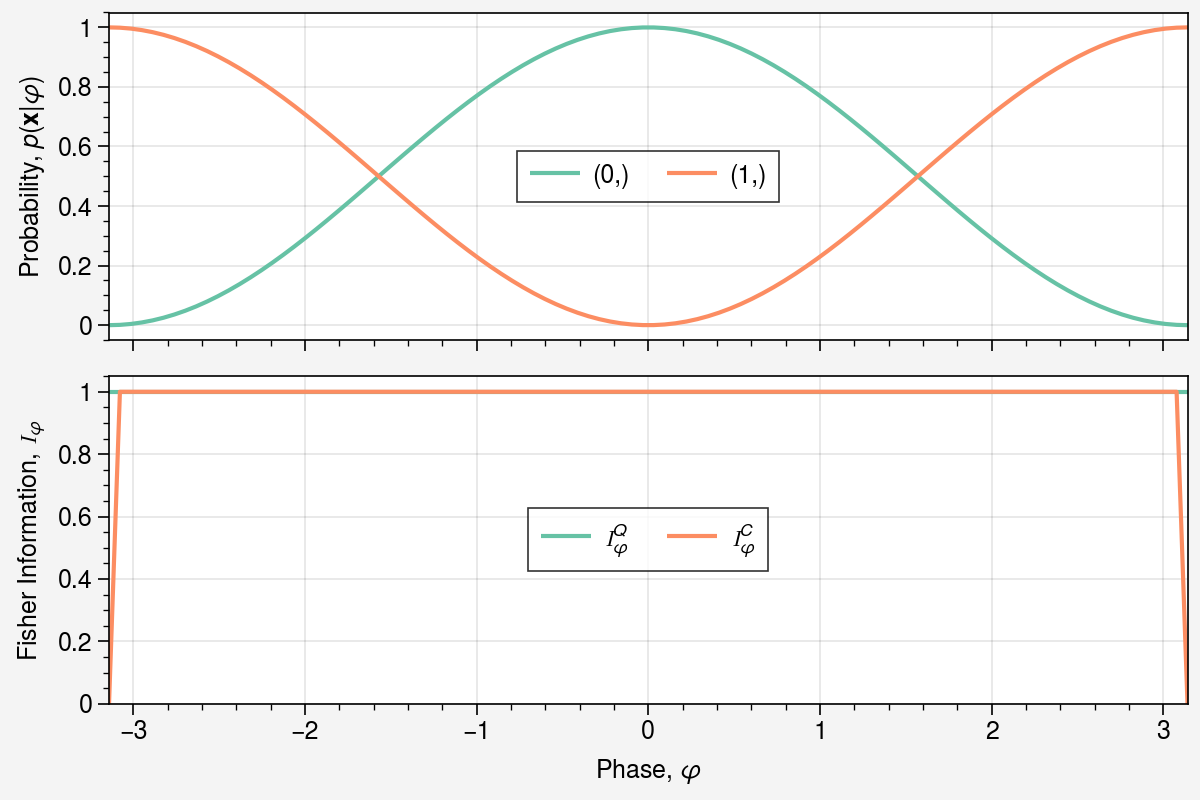

In [28]:
colors = sns.color_palette("Set2", n_colors=jnp.prod(jnp.array(probs.shape[1:])))
fig, axs = uplt.subplots(nrows=2, figsize=(6, 4), sharey=False)

for i, idx in enumerate(
    itertools.product(*[list(range(ell)) for ell in probs.shape[1:]])
):
    axs[0].plot(phis, probs[:, *idx], label=f"{idx}", color=colors[i])
axs[0].legend()
axs[0].set(xlabel=r"Phase, $\varphi$", ylabel=r"Probability, $p(\mathbf{x} | \varphi)$")

axs[1].plot(phis, qfims.squeeze(), color=colors[0], label=r"$\mathcal{I}_\varphi^Q$")
axs[1].plot(phis, cfims.squeeze(), color=colors[-1], label=r"$\mathcal{I}_\varphi^C$")
axs[1].set(
    xlabel=r"Phase, $\varphi$",
    ylabel=r"Fisher Information, $\mathcal{I}_\varphi$",
    ylim=[0, 1.05 * jnp.max(qfims)],
)
axs[1].legend();